In [44]:
from pathlib import Path
from diffusers import AutoPipelineForText2Image, UNet2DConditionModel
import torch

custom_sd_path = Path("/local/scratch/carlyn.1/diffusion_models/sd-ap-10k-model/")
custom_sd_path = "CompVis/stable-diffusion-v1-4"

custom_adapter_path = Path("/local/scratch/carlyn.1/diffusion_models/sd-ap-10k-model-T2I-pose-solo/")
#custom_adapter_path = Path("/local/scratch/carlyn.1/diffusion_models/sd-ap-10k-model-T2I-pose-PT/checkpoint-11000/t2iadapter")
pose_image_path = Path("/home/carlyn.1/code/FineDiffusion/pose_conditioning/notebooks/test_pose.png")

pipeline = AutoPipelineForText2Image.from_pretrained(
	custom_sd_path, torch_dtype=torch.float16, variant="fp16"
).to("cuda")

#pipeline.unet = UNet2DConditionModel.from_pretrained(custom_sd_path, subfolder="unet", torch_dtype=torch.float16).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/carlyn.1/miniconda3/envs/diffusion/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

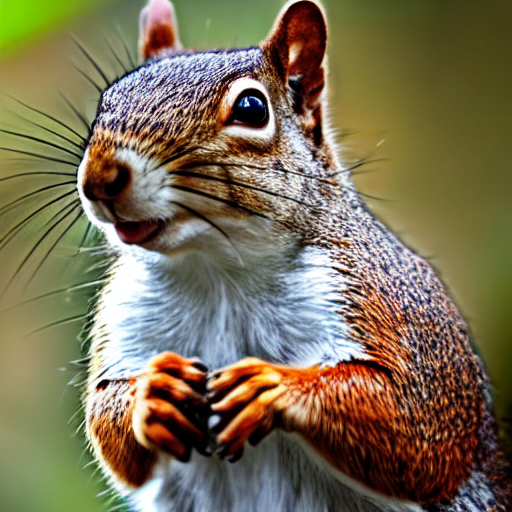

In [45]:
categories = [
	"jaguar", # Majority classes
	"weasel", # Majority classes
	"squirrel", # Majority classes
	"black bear", # Minority classes
	"marmot", # Minority classes
	"alouwatta", # Minority classes
	"dog", # Easy class
]

category = categories[2]
image = pipeline(
	f"A photo of a {category}"
).images[0]
image

In [46]:
import torch
from diffusers import StableDiffusionAdapterPipeline, T2IAdapter, EulerAncestralDiscreteScheduler

adapter = T2IAdapter.from_pretrained(custom_adapter_path, torch_dtype=torch.float16)
pipeline = StableDiffusionAdapterPipeline.from_pretrained(
    custom_sd_path,
    adapter=adapter,
    torch_dtype=torch.float16,
)
pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_xformers_memory_efficient_attention()

#pipeline.unet = UNet2DConditionModel.from_pretrained(custom_sd_path, subfolder="unet", torch_dtype=torch.float16)
pipeline.to("cuda")

print("loaded")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

loaded


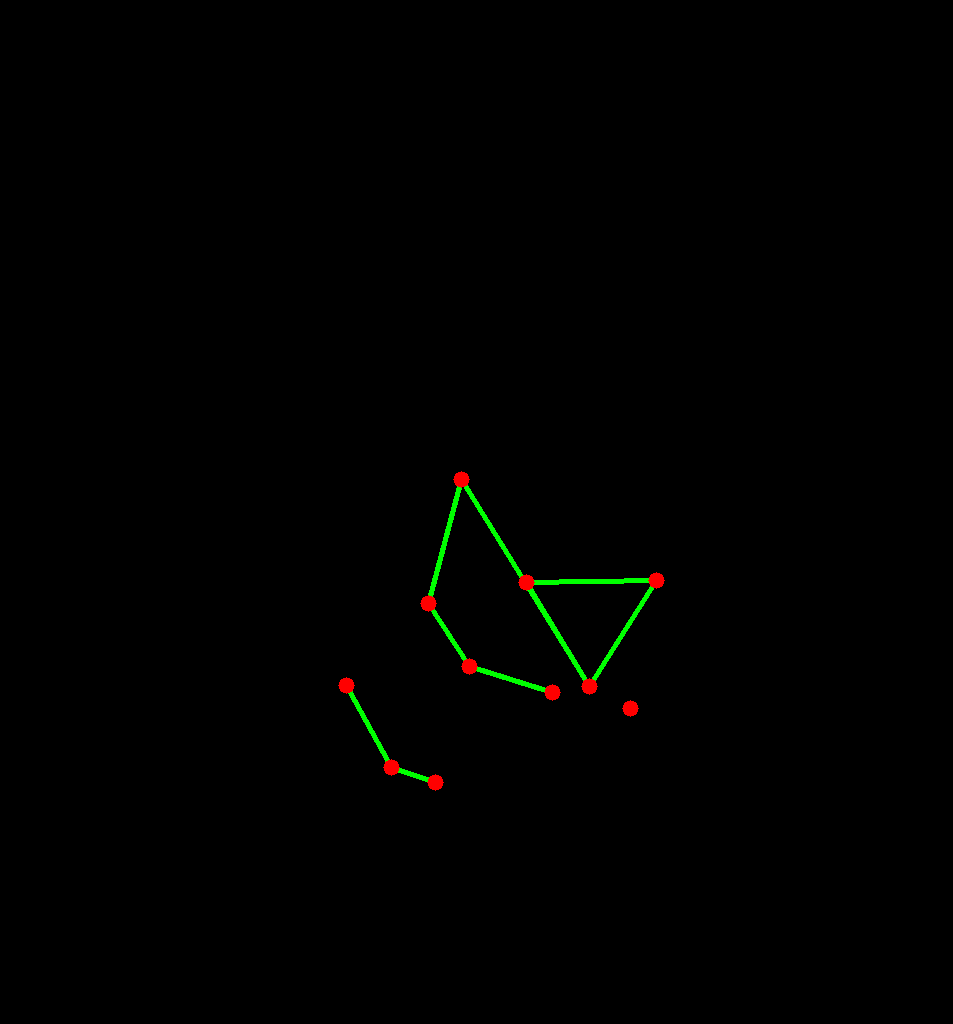

In [47]:
from diffusers.utils import load_image
cond_img = load_image(str(pose_image_path))
cond_img

  0%|          | 0/30 [00:00<?, ?it/s]

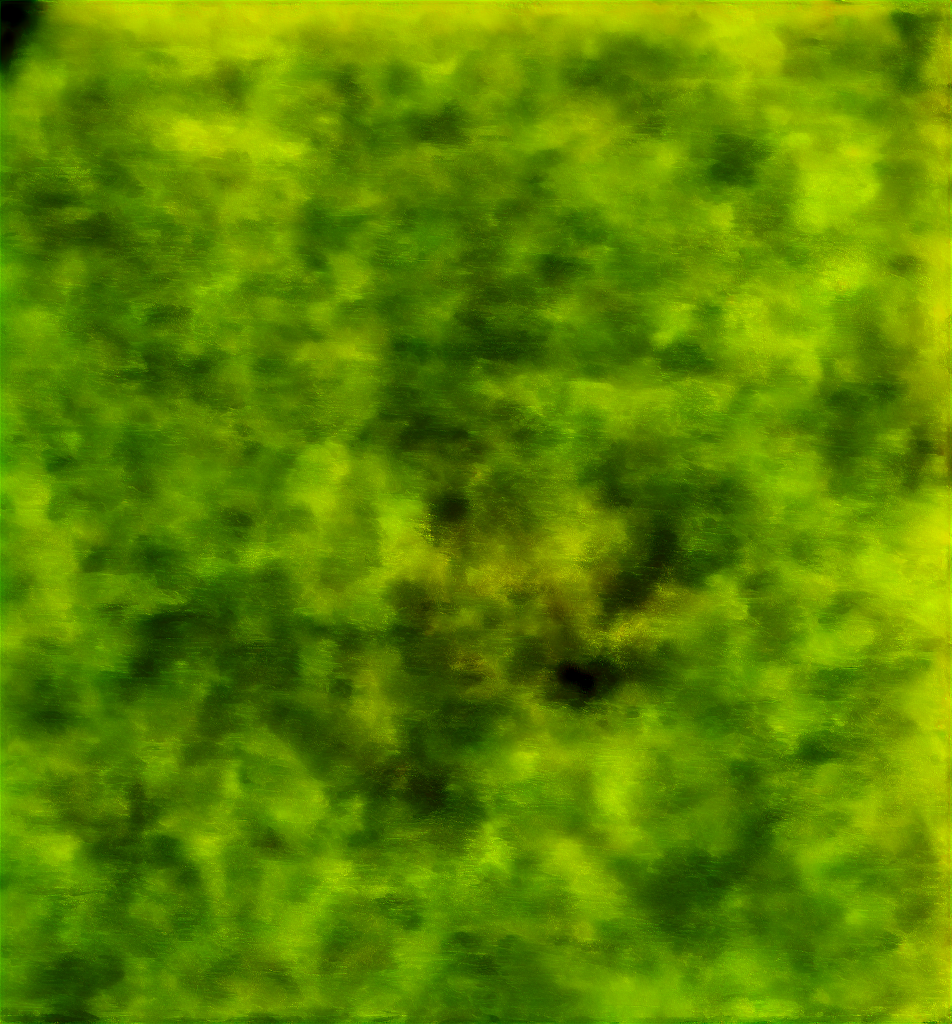

In [68]:
from PIL import Image
import numpy as np
from diffusers.utils import load_image

#cond_img = Image.open(pose_image_path)
cond_img = load_image(str(pose_image_path))

def null_safety(images, **kwargs):
      return images, False
pipeline.safety_checker = null_safety
image = pipeline(
	f"A photo of a {category}",
 	adapter_conditioning_scale=1,
	image=cond_img,
 	num_inference_steps=30,
	guidance_scale=7.5,
).images[0]

image